# Project 8 - Store Item Demand EDA and Forecasting

### Objective
* We are going to predict the store item sales number given a series of history data. For that data, we are going to use time series model to try to learn from the data. And please try to answer the following questions:
    1. How is the sales trend and growth rate over the 5 years?
    2. How is the sales trend by different stores?
    3. How is the sales trend by different items?
    4. Do you have any recommendations for the growth of the stores?
    5. Predict 3 months of sales for these 50 different items at 10 stores
    

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
%matplotlib inline
import datetime
import statsmodels.api as sm
import statsmodels.tsa.api as smt
from statsmodels.tools.eval_measures import rmse
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.ensemble import RandomForestRegressor
from xgboost.sklearn import XGBRegressor

import keras
from keras.layers import Dense
from keras.models import Sequential
from keras.optimizers import Adam 
from keras.callbacks import EarlyStopping
from keras.utils import np_utils
from keras.layers import LSTM
from sklearn.model_selection import KFold, cross_val_score, train_test_split

import pickle

Using TensorFlow backend.
/opt/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/opt/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/opt/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/opt/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py

# Data Exploration

In this part, we get familar with the data by doing the following:
    * Check out the shape of data and the data types of each column
    * whether there is null or NAs
    * The unique values and their counts in each columns
in addition, we extract the 'year' and the 'month' feature from the column 'date' for the purpose of convience

In [2]:
data = pd.read_csv('storedata.csv')
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 913000 entries, 0 to 912999
Data columns (total 4 columns):
date     913000 non-null object
store    913000 non-null int64
item     913000 non-null int64
sales    913000 non-null int64
dtypes: int64(3), object(1)
memory usage: 27.9+ MB


In [3]:
data.isnull().sum()

date     0
store    0
item     0
sales    0
dtype: int64

In [4]:
data.isna().sum()

date     0
store    0
item     0
sales    0
dtype: int64

In [5]:
for i in data.columns:
    print(data[i].value_counts())
    print("-----------------------------------------")

2016-03-13    500
2017-09-22    500
2015-07-09    500
2017-04-27    500
2017-08-16    500
             ... 
2017-12-29    500
2016-10-31    500
2014-04-12    500
2016-09-02    500
2014-12-22    500
Name: date, Length: 1826, dtype: int64
-----------------------------------------
10    91300
9     91300
8     91300
7     91300
6     91300
5     91300
4     91300
3     91300
2     91300
1     91300
Name: store, dtype: int64
-----------------------------------------
50    18260
13    18260
23    18260
22    18260
21    18260
20    18260
19    18260
18    18260
17    18260
16    18260
15    18260
14    18260
12    18260
49    18260
11    18260
10    18260
9     18260
8     18260
7     18260
6     18260
5     18260
4     18260
3     18260
2     18260
24    18260
25    18260
26    18260
27    18260
48    18260
47    18260
46    18260
45    18260
44    18260
43    18260
42    18260
41    18260
40    18260
39    18260
38    18260
37    18260
36    18260
35    18260
34    18260
33    18260
32   

In [6]:
data.head()

,date,store,item,sales
0,2013-01-01,1,1,13
1,2013-01-02,1,1,11
2,2013-01-03,1,1,14
3,2013-01-04,1,1,13
4,2013-01-05,1,1,10


Extract 'year' and 'month' from 'date'

In [7]:
df = data.copy()
df['year'] = df['date'].apply(lambda x: str(x)[:4])
df['month'] = df['date'].apply(lambda x: str(x)[:7])
df

,date,store,item,sales,year,month
0,2013-01-01,1,1,13,2013,2013-01
1,2013-01-02,1,1,11,2013,2013-01
2,2013-01-03,1,1,14,2013,2013-01
3,2013-01-04,1,1,13,2013,2013-01
4,2013-01-05,1,1,10,2013,2013-01
...,...,...,...,...,...,...
912995,2017-12-27,10,50,63,2017,2017-12
912996,2017-12-28,10,50,59,2017,2017-12
912997,2017-12-29,10,50,74,2017,2017-12
912998,2017-12-30,10,50,62,2017,2017-12


# 1 How is the sales trend and growth rate over the 5 years?

## Sales trend

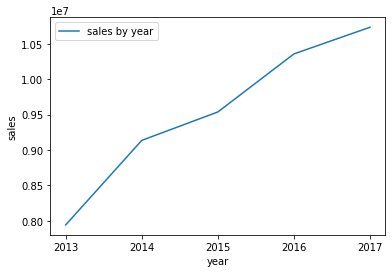

In [8]:
# Total Sales Trend By Year
x = list(df['year'].unique())
y_array = df[['sales','year']].groupby('year').sum().values
y = [i for item in y_array for i in item]
y_rate = [round(y[1]/y[0],3),round(y[2]/y[1],3),round(y[3]/y[2],3),round(y[4]/y[3],3)]
plt.plot(x,y,label='sales by year')
plt.legend()
plt.xlabel('year')
plt.ylabel('sales')
plt.show()

From the plot, we can see the sales trend is always growing over the 5 years and grows fastest during 2013 to 2014

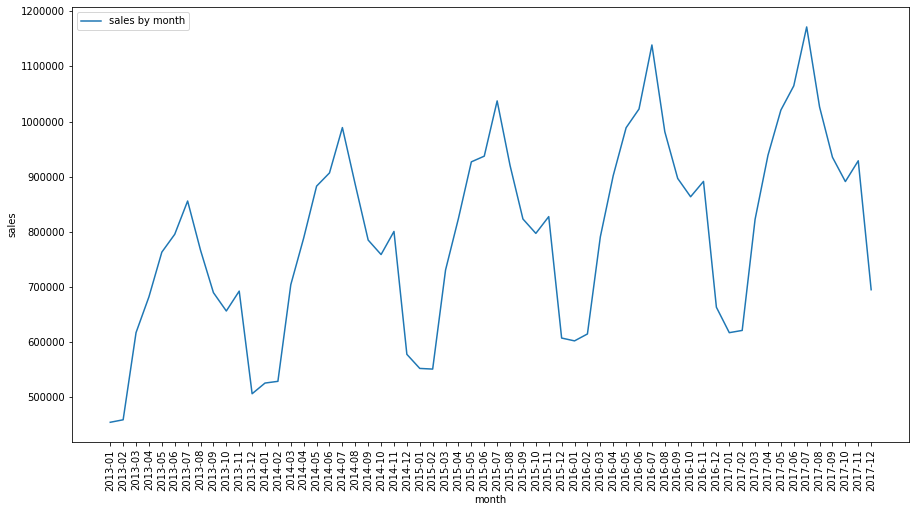

In [9]:
# Total Sales Trend By Month
x = list(df['month'].unique())
y_array = df[['sales','month']].groupby('month').sum().values
y = [i for item in y_array for i in item]
m_rate = []
for i in range(len(y)-1):
    m_rate.append(round(y[i+1]/y[i],3))
plt.figure(figsize=(15,8))
plt.plot(x,y,label='sales by month')
plt.xticks(rotation=90)
plt.legend()
plt.xlabel('month')
plt.ylabel('sales')
plt.show()

From the plot, we can see the sales is always highest of the year at July, which may caused by summer vacation. In addition, during November, there is a small peak caused by Thanks' Giving Day.

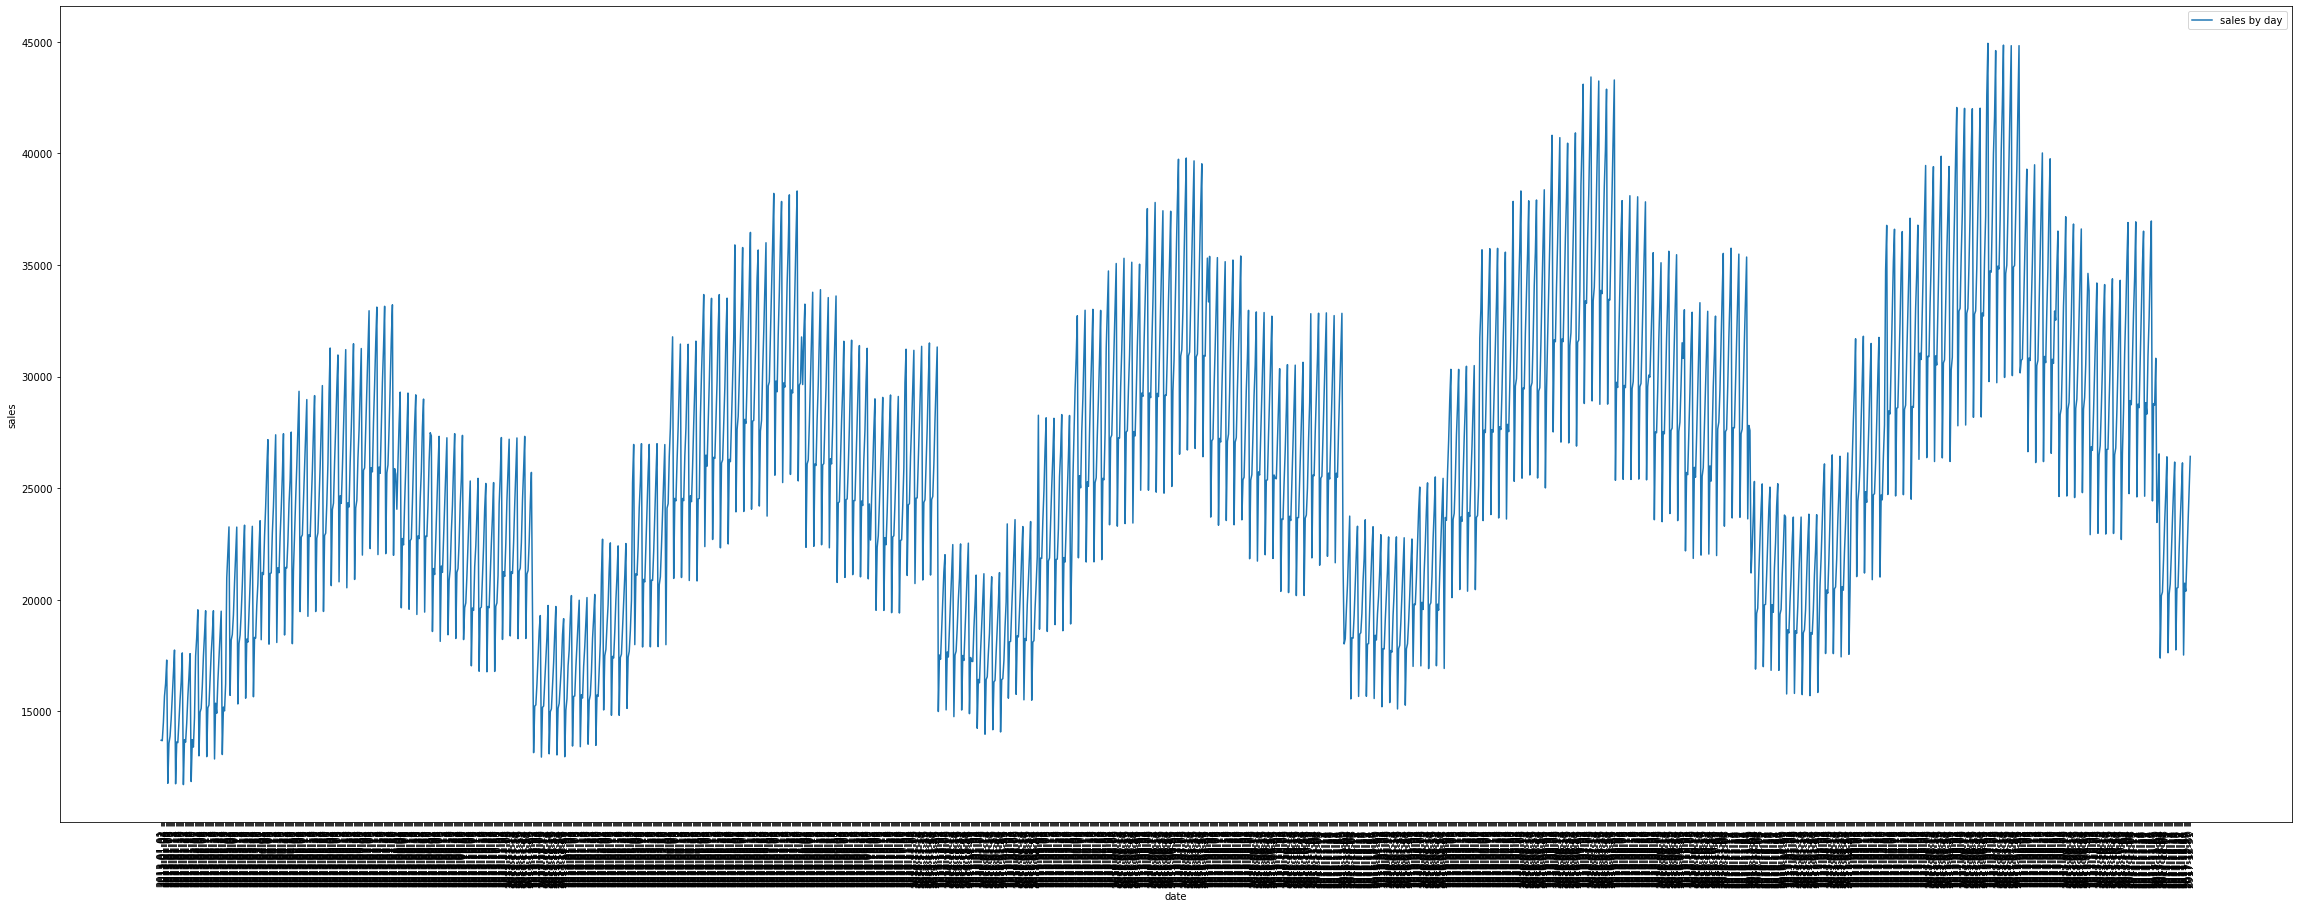

In [10]:
# Total Sales Trend By Date
x = list(df['date'].unique())
y_array = df[['sales','date']].groupby('date').sum().values
plt.figure(figsize=(40,15))
plt.plot(x,y_array,label='sales by day')
plt.xticks(rotation=90)
plt.legend()
plt.xlabel('date')
plt.ylabel('sales')
plt.show()

## Growth rate

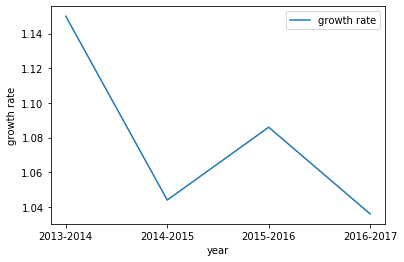

In [11]:
# Total Growth Rate By Year
# y_rate = [round(y[1]/y[0],3),round(y[2]/y[1],3),round(y[3]/y[2],3),round(y[4]/y[3],3)]
plt.plot(['2013-2014','2014-2015','2015-2016','2016-2017'],y_rate,label='growth rate')
plt.legend()
plt.xlabel('year')
plt.ylabel('growth rate')
plt.show()

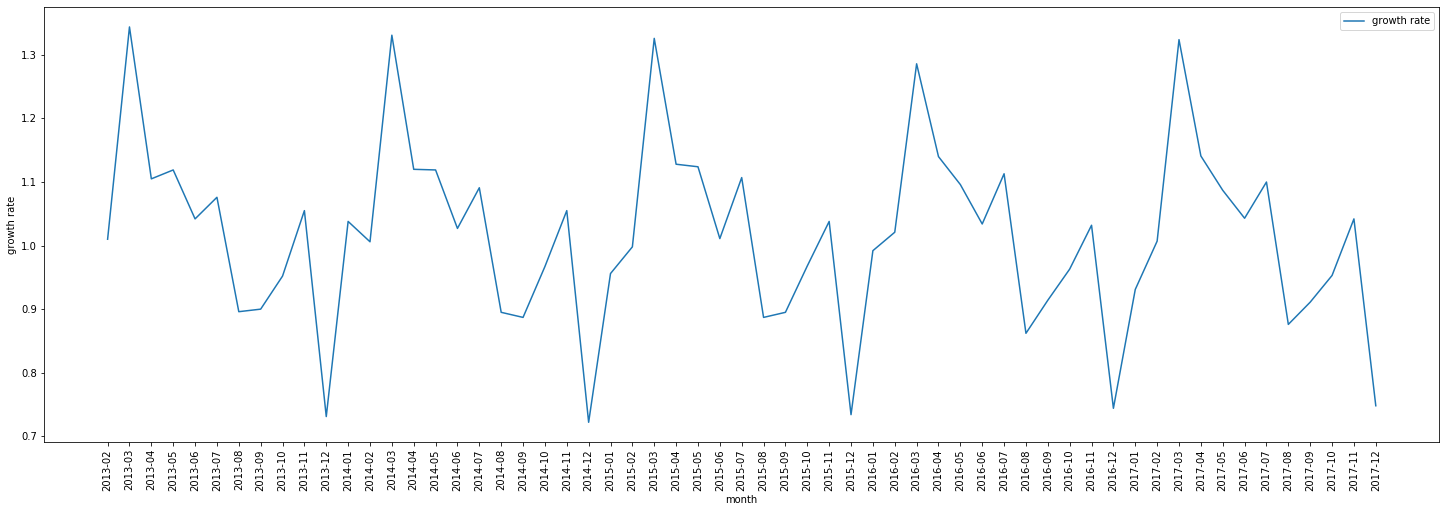

In [12]:
# Total Growth Rate By Month
plt.figure(figsize=(25,8))
plt.plot(list(df['month'].unique())[1:],m_rate,label='growth rate')
plt.legend()
plt.xticks(rotation=90)
plt.xlabel('month')
plt.ylabel('growth rate')
plt.show()

# 2 How is the sales trend by different stores?

## Each line represents a store's sales trend over the 5 years

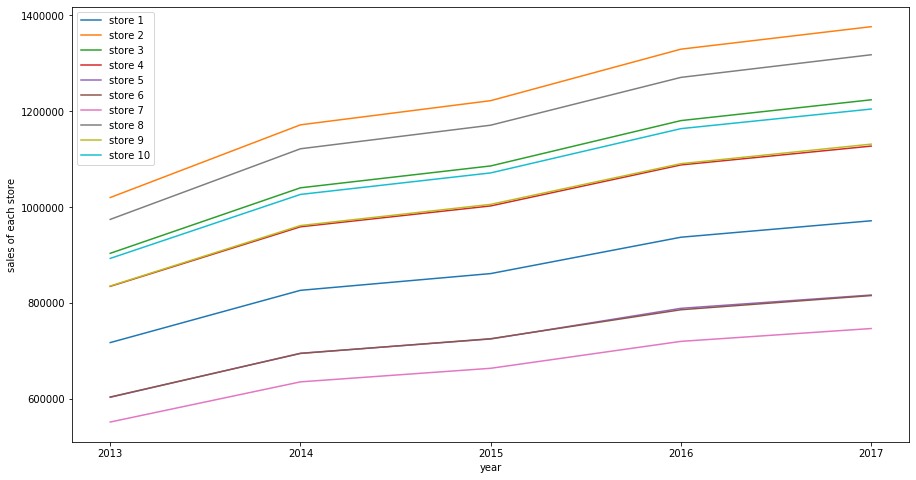

In [13]:
# Sales Trend For Each Store By Year
x = list(df['year'].unique())
stores = list(df['store'].unique())
y_growth_rate = {}
plt.figure(figsize=(15,8))
for i in stores:
    y_array = df.loc[df['store'] == i][['year','sales']].groupby('year').sum().values
    y = [i for item in y_array for i in item]
    y_rate = [round(y[1]/y[0],3),round(y[2]/y[1],3),round(y[3]/y[2],3),round(y[4]/y[3],3)]
    y_growth_rate[i] = y_rate
    plt.plot(x,y,label = 'store '+ str(i))
plt.legend()
plt.xlabel('year')
plt.ylabel('sales of each store')
plt.show()

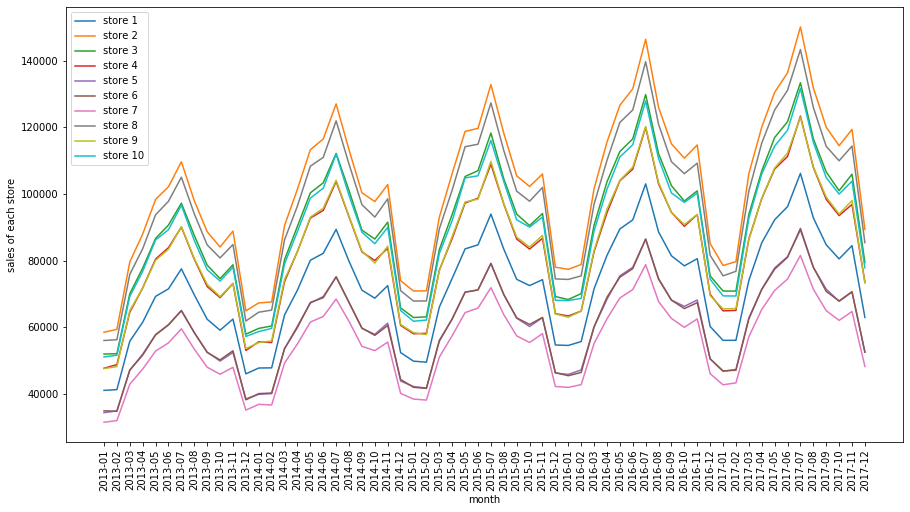

In [14]:
# Sales Trend For Each Store By Month
x = list(df['month'].unique())
stores = list(df['store'].unique())
m_growth_rate = {}
plt.figure(figsize=(15,8))
for i in stores:
    y_array = df.loc[df['store'] == i][['month','sales']].groupby('month').sum().values
    y = [i for item in y_array for i in item]
    m_rate = []
    for j in range(len(y)-1):
        m_rate.append(round(y[j+1]/y[j],3))
    m_growth_rate[i] = m_rate
    plt.plot(x,y,label = 'store '+ str(i))
plt.xticks(rotation=90)
plt.legend()
plt.xlabel('month')
plt.ylabel('sales of each store')
plt.show()

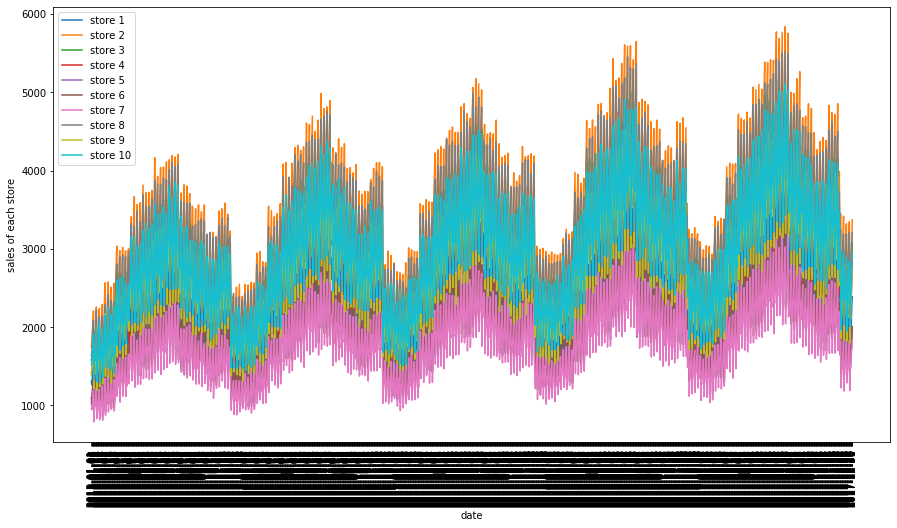

In [15]:
# Sales Trend For Each Store By Date
x = list(df['date'].unique())
stores = list(df['store'].unique())
plt.figure(figsize=(15,8))
for i in stores:
    y_array = df.loc[df['store'] == i][['date','sales']].groupby('date').sum().values
    y = [i for item in y_array for i in item]
    plt.plot(x,y,label = 'store '+ str(i))
plt.xticks(rotation=90)
plt.legend()
plt.xlabel('date')
plt.ylabel('sales of each store')
plt.show()

## Each row shows the growth rate of that store over the 5 years

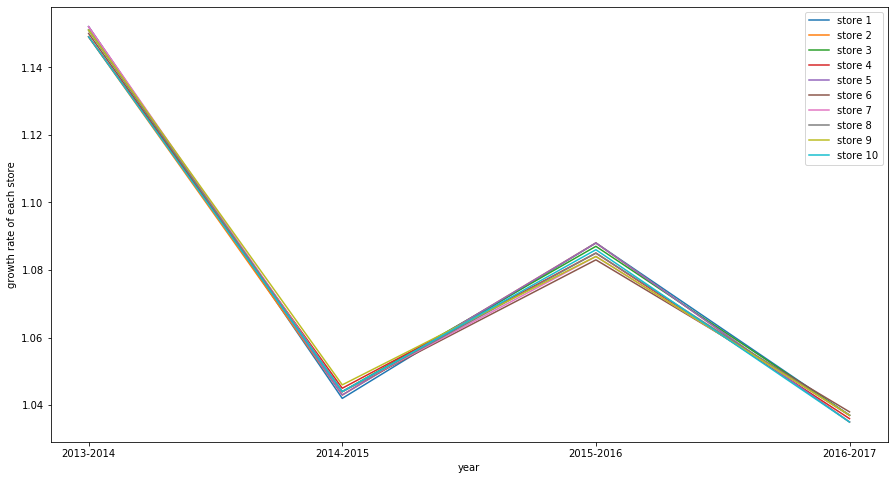

In [16]:
# Growth Rate For Each Store By Year
s_gr_df = pd.DataFrame(y_growth_rate)

# transposition
s_growth_rate_df = pd.DataFrame(s_gr_df.values.T, index=s_gr_df.columns, 
                              columns=['2013-2014','2014-2015','2015-2016','2016-2017'])

# plot
x = ['2013-2014','2014-2015','2015-2016','2016-2017']
plt.figure(figsize=(15,8))
for i in s_growth_rate_df.index:
    y_array = s_growth_rate_df.iloc[i-1].values
    plt.plot(x,y_array,label = 'store '+ str(i))
plt.legend()
plt.xlabel('year')
plt.ylabel('growth rate of each store')
plt.show()

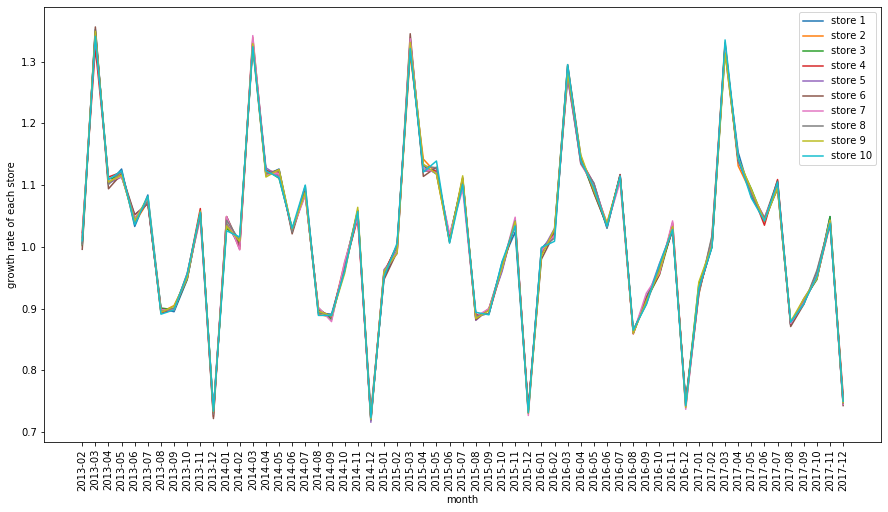

In [17]:
# Growth Rate For Each Store By Month
s_gr_df = pd.DataFrame(m_growth_rate)

# transposition
s_growth_rate_df = pd.DataFrame(s_gr_df.values.T, index=s_gr_df.columns, 
                              columns= list(df['month'].unique())[1:])

# plot
x = list(df['month'].unique())[1:]
plt.figure(figsize=(15,8))
for i in s_growth_rate_df.index:
    y_array = s_growth_rate_df.iloc[i-1].values
    plt.plot(x,y_array,label = 'store '+ str(i))
plt.xticks(rotation=90)
plt.legend()
plt.xlabel('month')
plt.ylabel('growth rate of each store')
plt.show()

# 3 How is the sales trend by different items?

## Each line represents an item's sales trend over the 5 years

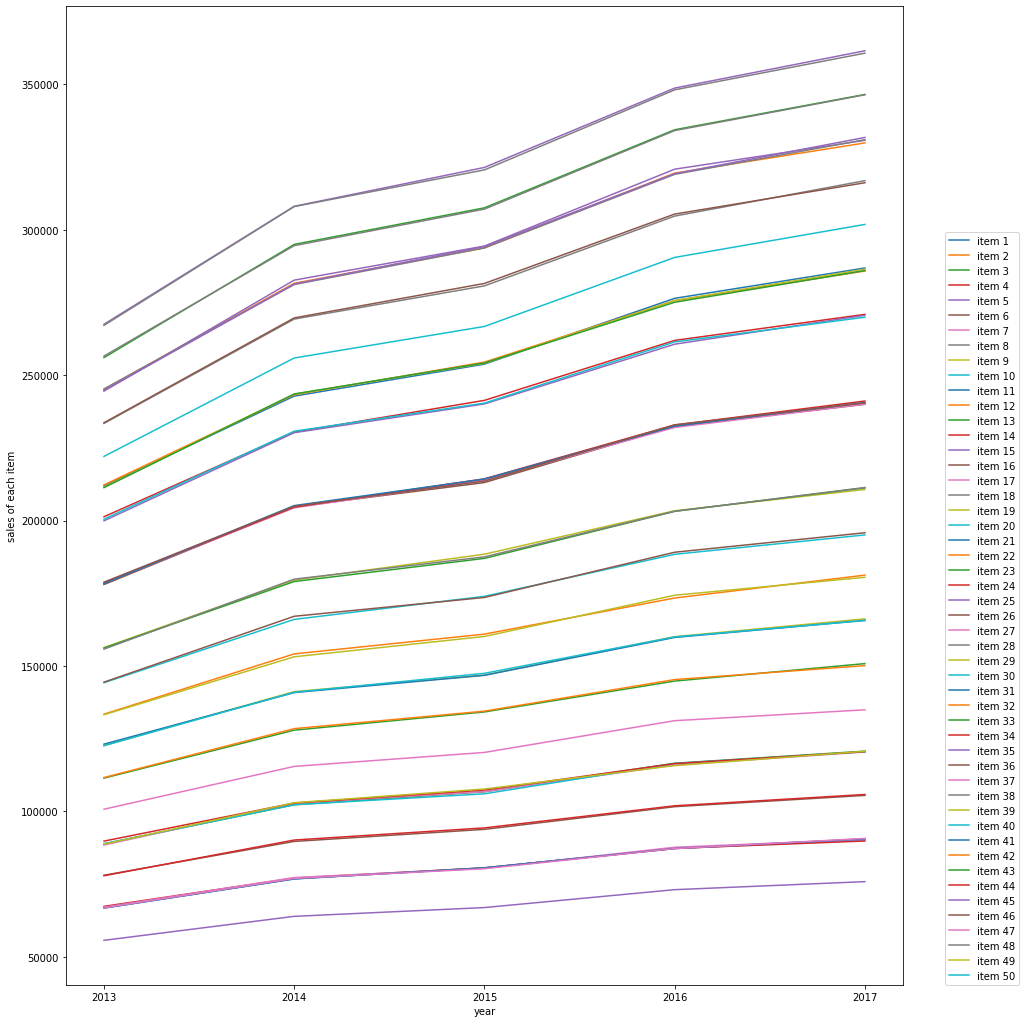

In [18]:
# Sales Trend For Each Item By Year
x = list(df['year'].unique())
items = list(df['item'].unique())
y_growth_rate = {}
plt.figure(figsize=(15,18))
for i in items:
    y_array = df.loc[df['item'] == i][['year','sales']].groupby('year').sum().values
    y = [i for item in y_array for i in item]
    y_rate = [round(y[1]/y[0],3),round(y[2]/y[1],3),round(y[3]/y[2],3),round(y[4]/y[3],3)]
    y_growth_rate[i] = y_rate
    plt.plot(x,y,label = 'item '+ str(i))
plt.legend(bbox_to_anchor=(1.05, 0), loc=3, borderaxespad=0)
plt.xlabel('year')
plt.ylabel('sales of each item')
plt.show()

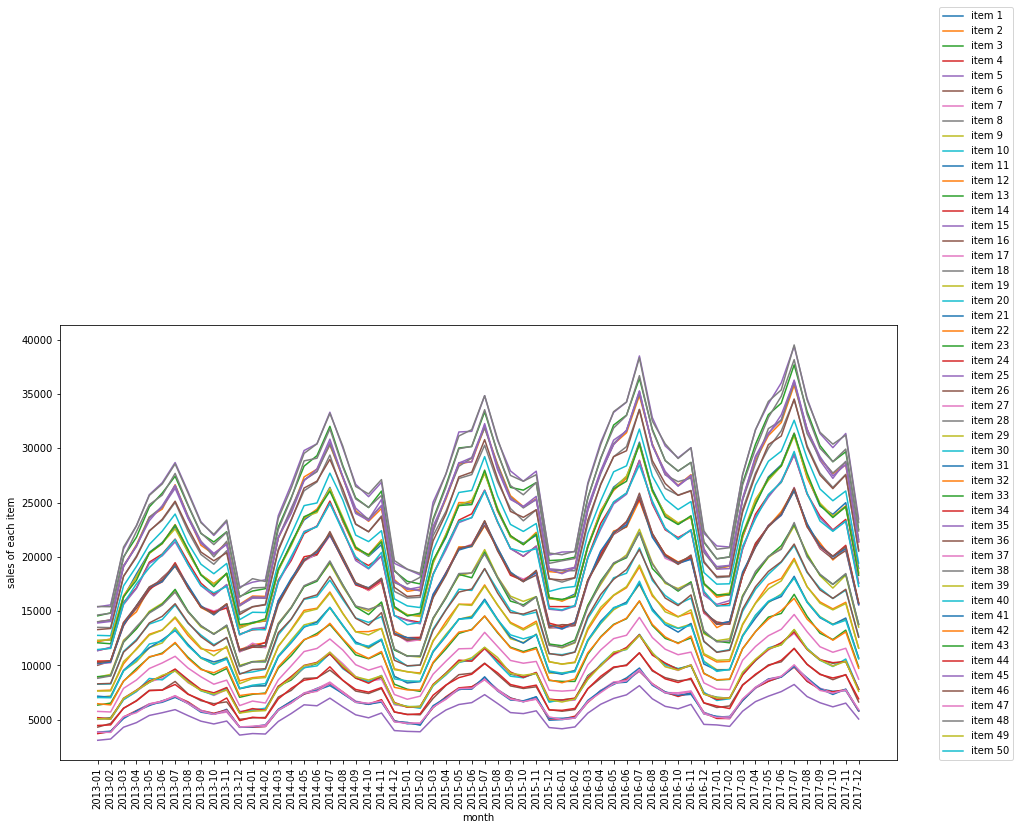

In [19]:
# Sales Trend For Each Item By Month
x = list(df['month'].unique())
items = list(df['item'].unique())
m_growth_rate = {}
plt.figure(figsize=(15,8))
for i in items:
    y_array = df.loc[df['item'] == i][['month','sales']].groupby('month').sum().values
    y = [i for item in y_array for i in item]
    m_rate = []
    for j in range(len(y)-1):
        m_rate.append(round(y[j+1]/y[j],3))
    m_growth_rate[i] = m_rate
    plt.plot(x,y,label = 'item '+ str(i))
plt.xticks(rotation=90)
plt.legend(bbox_to_anchor=(1.05, 0), loc=3, borderaxespad=0)
plt.xlabel('month')
plt.ylabel('sales of each item')
plt.show()

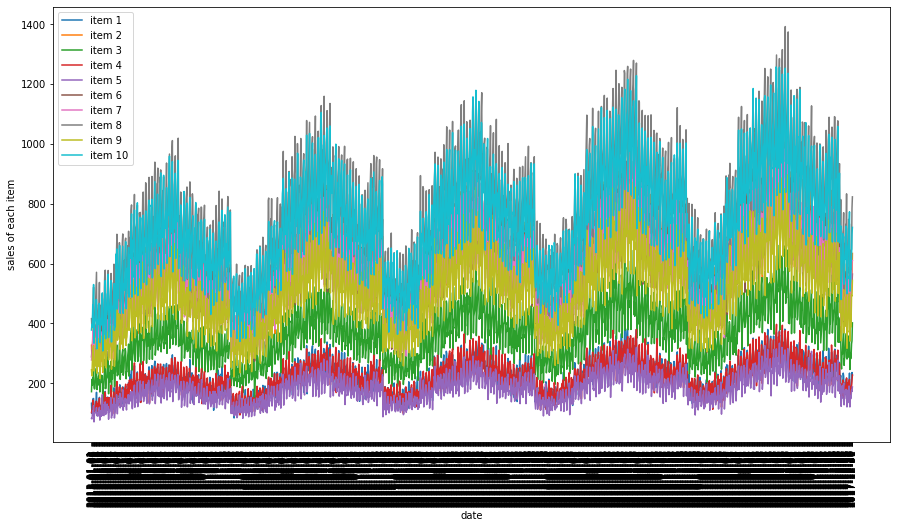

In [20]:
# Sales Trend For Each Item By Date
x = list(df['date'].unique())
items = list(df['item'].unique())
plt.figure(figsize=(15,8))
for i in stores:
    y_array = df.loc[df['item'] == i][['date','sales']].groupby('date').sum().values
    y = [i for item in y_array for i in item]
    plt.plot(x,y,label = 'item '+ str(i))
plt.xticks(rotation=90)
plt.legend()
plt.xlabel('date')
plt.ylabel('sales of each item')
plt.show()

## Each row shows the growth rate of that item over the 5 years

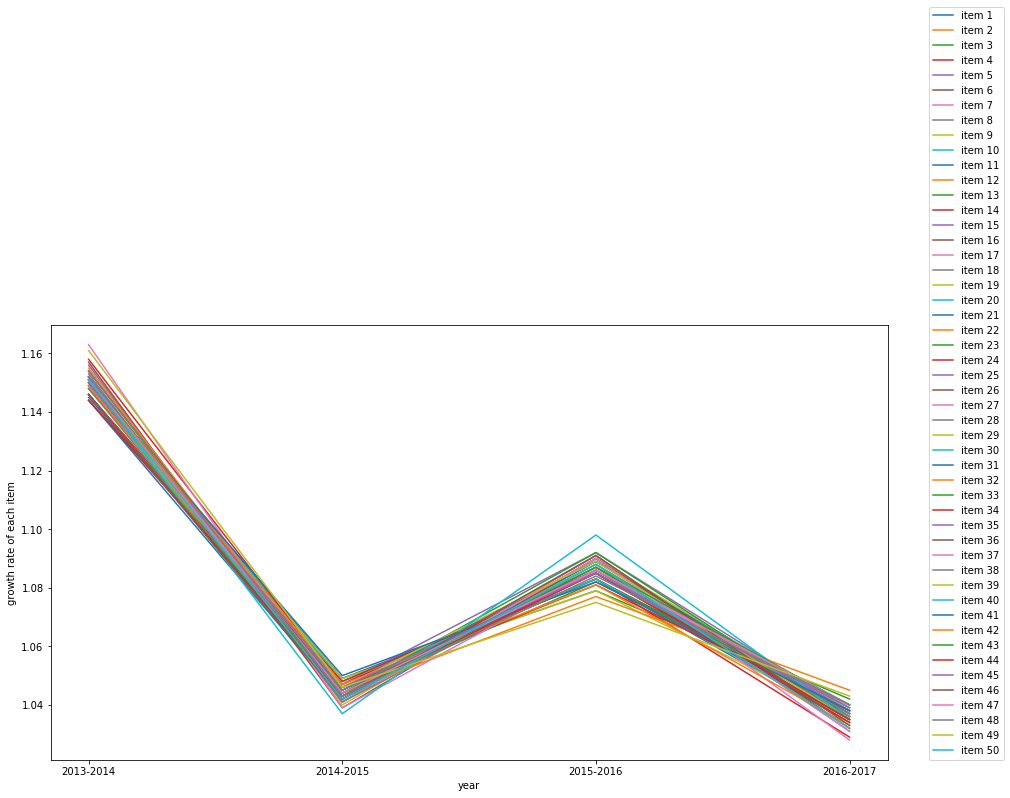

In [21]:
# Growth Rate For Each Item By Year
s_gr_df = pd.DataFrame(y_growth_rate)

# transposition
s_growth_rate_df = pd.DataFrame(s_gr_df.values.T, index=s_gr_df.columns, 
                              columns=['2013-2014','2014-2015','2015-2016','2016-2017'])

# plot
x = ['2013-2014','2014-2015','2015-2016','2016-2017']
plt.figure(figsize=(15,8))
for i in s_growth_rate_df.index:
    y_array = s_growth_rate_df.iloc[i-1].values
    plt.plot(x,y_array,label = 'item '+ str(i))
plt.legend(bbox_to_anchor=(1.05, 0), loc=3, borderaxespad=0)
plt.xlabel('year')
plt.ylabel('growth rate of each item')
plt.show()

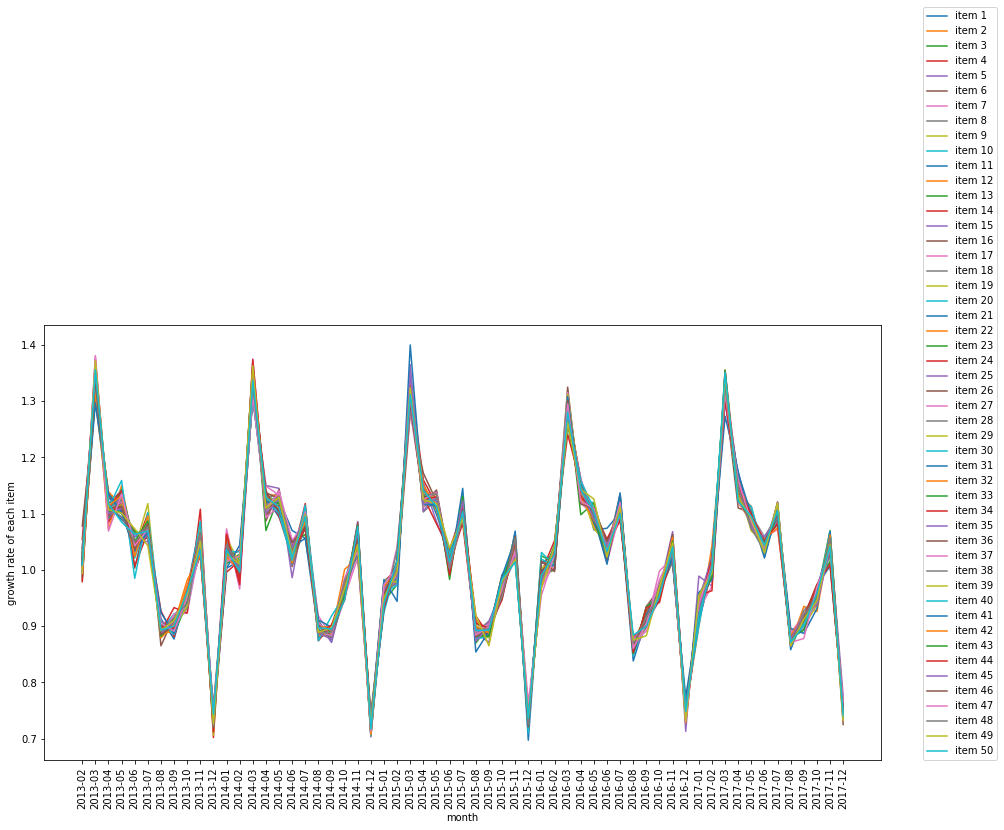

In [22]:
# Growth Rate For Each Item By Month
s_gr_df = pd.DataFrame(m_growth_rate)

# transposition
s_growth_rate_df = pd.DataFrame(s_gr_df.values.T, index=s_gr_df.columns, 
                              columns= list(df['month'].unique())[1:])

# plot
x = list(df['month'].unique())[1:]
plt.figure(figsize=(15,8))
for i in s_growth_rate_df.index:
    y_array = s_growth_rate_df.iloc[i-1].values
    plt.plot(x,y_array,label = 'item '+ str(i))
plt.xticks(rotation=90)
plt.legend(bbox_to_anchor=(1.05, 0), loc=3, borderaxespad=0)
plt.xlabel('month')
plt.ylabel('growth rate of each item')
plt.show()

# 4 Do you have any recommendations for the growth of the stores?

All the 10 stores and the 50 items have similar sales trend, highest growth in 2015 compared to 2014, lower growth in 2015, then growth rate rises a little bit in 2016, but fall to lowest in 2017. This may indicates the growth is influenced by the whole economic environment and the market.
In addition, the time-series has seasonality pattern, such as sales are always low at the beginning of the year and high at the middle(festive season maybe) of the year and again low at the end of the year. There is always an upward trend within any single year with a couple of low months in the mid of the year.
For the stores, there may not much thing they can do. However, they can always find some way to make the sales growth become better, such as increasing sales opportunities, improving customer service, adding new products or product lines, etc.

# 5 Predict 3 months of sales for these 50 different items at 10 stores

In [23]:
df_month = df[['month','store','item','sales']].groupby(['month','store','item']).sum().reset_index()
df_month

,month,store,item,sales
0,2013-01,1,1,328
1,2013-01,1,2,911
2,2013-01,1,3,547
3,2013-01,1,4,346
4,2013-01,1,5,276
...,...,...,...,...
29995,2017-12,10,46,1723
29996,2017-12,10,47,626
29997,2017-12,10,48,1537
29998,2017-12,10,49,815


## 5.1 Determining Stationarity

In [24]:
# singles_df = []
# for i in df_month['store'].values:
#     for j in df_month['item'].values:
#         monthly_single = df_month.loc[df_month['store'] == i].loc[df_month['item'] == j]
#         singles_df.append(monthly_single)

In [25]:
# create DataFrame for monthly sales
def monthly_sales(data):
    monthly_data = data.copy()
    monthly_data.date = monthly_data.date.apply(lambda x: str(x)[:-3])
    monthly_data = monthly_data.groupby('date')['sales'].sum().reset_index()
    monthly_data.date = pd.to_datetime(monthly_data.date)
    return monthly_data


monthly_df = monthly_sales(data)
monthly_df.head()

,date,sales
0,2013-01-01,454904
1,2013-02-01,459417
2,2013-03-01,617382
3,2013-04-01,682274
4,2013-05-01,763242


/opt/anaconda3/lib/python3.7/site-packages/pandas/plotting/_matplotlib/converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


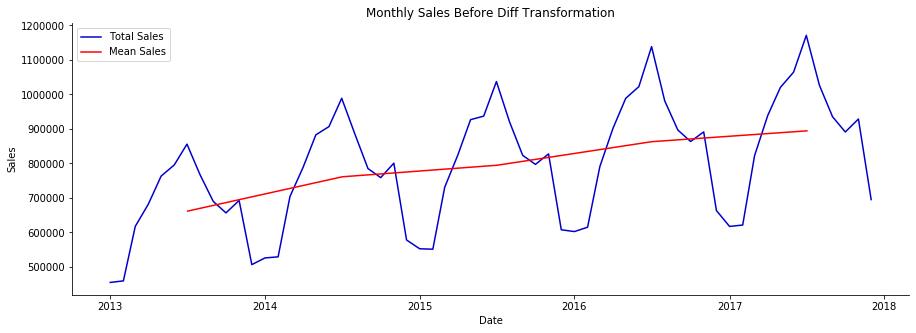

In [26]:
# Plot the sales of every month and mean of every year to determine stationary
def time_plot(data, x_col, y_col, title):
    fig, ax = plt.subplots(figsize=(15,5))
    sns.lineplot(x_col, y_col, data=data, ax=ax, color='mediumblue', label='Total Sales')
    
    second = data.groupby(data.date.dt.year)[y_col].mean().reset_index()
    second.date = pd.to_datetime(second.date, format='%Y')
    sns.lineplot((second.date + datetime.timedelta(6*365/12)), y_col, data=second, ax=ax, color='red', label='Mean Sales')   
    
    ax.set(xlabel = "Date",
           ylabel = "Sales",
           title = title)
    
    sns.despine()
    
time_plot(monthly_df, 'date', 'sales', 'Monthly Sales Before Diff Transformation')

The plot clearly shows that the sales is unstable, along with its obvious seasonality.

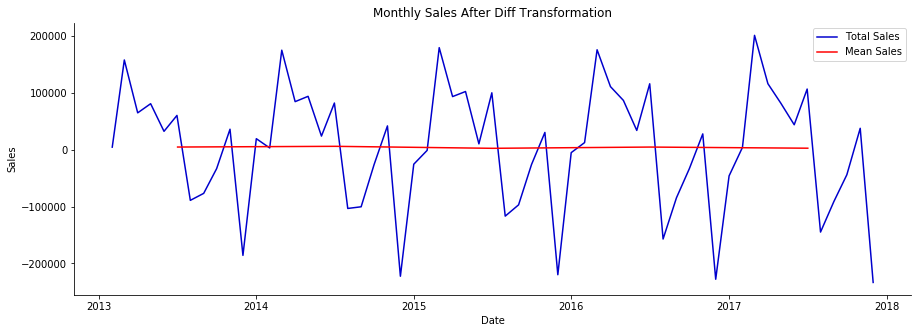

In [27]:
# Calculate the difference between every neighbor two months
def get_diff(data):
    data['sales_diff'] = data.sales.diff()
    data = data.dropna()
    return data

stationary_df = get_diff(monthly_df)
time_plot(stationary_df, 'date', 'sales_diff', 'Monthly Sales After Diff Transformation')

## 5.2 Feature Engineering

Now we can start building our feature set. We need to use previous monthly sales data to forecast the next ones. The look-back period (lag period) may vary for every model. Ours will be 12 for this example.

Different models may need different feature.

### 5.2.1 For Regressive Modeling

In [28]:
# Create dataframe for transformation from time series to supervised
def generate_supervised(data):
    supervised_df = data.copy()
    
    #create column for each lag
    for i in range(1,13):
        col_name = 'lag_' + str(i)
        supervised_df[col_name] = supervised_df['sales_diff'].shift(i)
    
    #drop null values
    supervised_df = supervised_df.dropna().reset_index(drop=True)
    
    return supervised_df


model_df = generate_supervised(stationary_df)
model_df.head()

,date,sales,sales_diff,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,lag_8,lag_9,lag_10,lag_11,lag_12
0,2014-02-01,529117,3130.0,19380.0,-186036.0,36056.0,-33320.0,-76854.0,-89161.0,60325.0,32355.0,80968.0,64892.0,157965.0,4513.0
1,2014-03-01,704301,175184.0,3130.0,19380.0,-186036.0,36056.0,-33320.0,-76854.0,-89161.0,60325.0,32355.0,80968.0,64892.0,157965.0
2,2014-04-01,788914,84613.0,175184.0,3130.0,19380.0,-186036.0,36056.0,-33320.0,-76854.0,-89161.0,60325.0,32355.0,80968.0,64892.0
3,2014-05-01,882877,93963.0,84613.0,175184.0,3130.0,19380.0,-186036.0,36056.0,-33320.0,-76854.0,-89161.0,60325.0,32355.0,80968.0
4,2014-06-01,906842,23965.0,93963.0,84613.0,175184.0,3130.0,19380.0,-186036.0,36056.0,-33320.0,-76854.0,-89161.0,60325.0,32355.0


### 5.2.2 For ARIMA Modeling

In [29]:
def generate_arima_data(data):
    dt_data = data.set_index('date').drop('sales', axis=1)
    dt_data.dropna(axis=0)
    
    return dt_data


arima_df = generate_arima_data(stationary_df)
arima_df

,sales_diff
date,
2013-02-01,4513.0
2013-03-01,157965.0
2013-04-01,64892.0
2013-05-01,80968.0
2013-06-01,32355.0
2013-07-01,60325.0
2013-08-01,-89161.0
2013-09-01,-76854.0
2013-10-01,-33320.0


## 5.3 Modeling

In [30]:
def tts(data):
    data = data.drop(['sales','date'],axis=1)
    train, test = data[0:-3].values, data[-3:].values
    
    return train, test

train, test = tts(model_df)

### 5.3.1 Regressive model

In [31]:
def scale_data(train_set, test_set):
    #apply Min Max Scaler
    scaler = MinMaxScaler(feature_range=(-1, 1))
    scaler = scaler.fit(train_set)
    
    # reshape training set
    train_set = train_set.reshape(train_set.shape[0], train_set.shape[1])
    train_set_scaled = scaler.transform(train_set)
    
    # reshape test set
    test_set = test_set.reshape(test_set.shape[0], test_set.shape[1])
    test_set_scaled = scaler.transform(test_set)
    
    X_train, y_train = train_set_scaled[:, 1:], train_set_scaled[:, 0:1].ravel()
    X_test, y_test = test_set_scaled[:, 1:], test_set_scaled[:, 0:1].ravel()
    
    return X_train, y_train, X_test, y_test, scaler

X_train, y_train, X_test, y_test, scaler_object = scale_data(train, test)

In [32]:
def undo_scaling(y_pred, x_test, scaler_obj, lstm=False):  
    #reshape y_pred
    y_pred = y_pred.reshape(y_pred.shape[0], 1, 1)
    
    if not lstm:
        x_test = x_test.reshape(x_test.shape[0], 1, x_test.shape[1])
    
    #rebuild test set for inverse transform
    pred_test_set = []
    for index in range(0,len(y_pred)):
        pred_test_set.append(np.concatenate([y_pred[index],x_test[index]],axis=1))
        
    #reshape pred_test_set
    pred_test_set = np.array(pred_test_set)
    pred_test_set = pred_test_set.reshape(pred_test_set.shape[0], pred_test_set.shape[2])
    
    #inverse transform
    pred_test_set_inverted = scaler_obj.inverse_transform(pred_test_set)
    
    return pred_test_set_inverted

In [33]:
def load_original_df():
    #load in original dataframe without scaling applied
    original_df = data.copy()
    original_df.date = original_df.date.apply(lambda x: str(x)[:-3])
    original_df = original_df.groupby('date')['sales'].sum().reset_index()
    original_df.date = pd.to_datetime(original_df.date)
    return original_df

In [34]:
def predict_df(unscaled_predictions, original_df):
    # create dataframe that shows the predicted sales
    result_list = []
    sales_dates = list(original_df[-4:].date)
    act_sales = list(original_df[-4:].sales)
    
    for index in range(0,len(unscaled_predictions)):
        result_dict = {}
        result_dict['pred_value'] = int(unscaled_predictions[index][0] + act_sales[index])
        result_dict['date'] = sales_dates[index+1]
        result_list.append(result_dict)
        
    df_result = pd.DataFrame(result_list)
    
    return df_result

In [35]:
model_scores = {}

def get_scores(unscaled_df, original_df, model_name):
    rmse = np.sqrt(mean_squared_error(original_df.sales[-3:], unscaled_df.pred_value[-3:]))
    mae = mean_absolute_error(original_df.sales[-3:], unscaled_df.pred_value[-3:])
    r2 = r2_score(original_df.sales[-3:], unscaled_df.pred_value[-3:])
    model_scores[model_name] = [rmse, mae, r2]

    print(f"RMSE: {rmse}")
    print(f"MAE: {mae}")
    print(f"R2 Score: {r2}")

In [36]:
def plot_results(results, original_df, model_name):

    fig, ax = plt.subplots(figsize=(15,5))
    sns.lineplot(original_df.date, original_df.sales, data=original_df, ax=ax, 
                 label='Original', color='mediumblue')
    sns.lineplot(results.date, results.pred_value, data=results, ax=ax, 
                 label='Predicted', color='Red')
    
    ax.set(xlabel = "Date",
           ylabel = "Sales",
           title = f"{model_name} Sales Forecasting Prediction")
    
    ax.legend()
    
    sns.despine()

In [37]:
def run_model(train_data, test_data, model, model_name):
    
    X_train, y_train, X_test, y_test, scaler_object = scale_data(train_data, test_data)
    
    mod = model
    mod.fit(X_train, y_train)
    predictions = mod.predict(X_test)
    
    # Undo scaling to compare predictions against original data
    original_df = load_original_df()
    unscaled = undo_scaling(predictions, X_test, scaler_object)
    unscaled_df = predict_df(unscaled, original_df)
      
    get_scores(unscaled_df, original_df, model_name)
    
    plot_results(unscaled_df, original_df, model_name)

#### 5.3.1. a)  Linear Regression

RMSE: 13034.26302737008
MAE: 10832.0
R2 Score: 0.9838081404665647


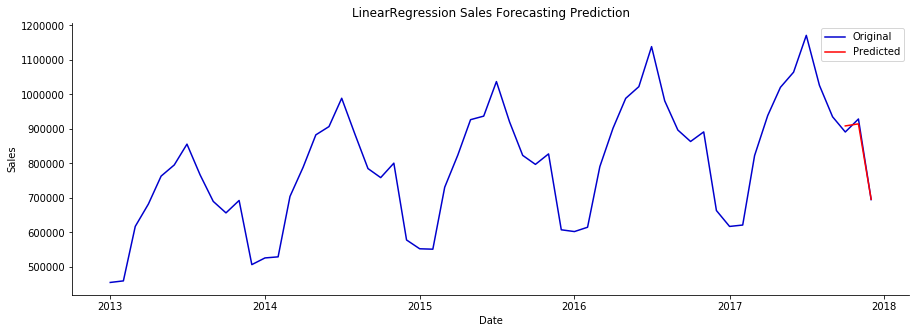

In [38]:
run_model(train, test, LinearRegression(), 'LinearRegression')

#### 5.3.1. b)  LSTM

In [39]:
def lstm_model(train_data, test_data):
    
    X_train, y_train, X_test, y_test, scaler_object = scale_data(train_data, test_data)
    
    X_train = X_train.reshape(X_train.shape[0], 1, X_train.shape[1])
    X_test = X_test.reshape(X_test.shape[0], 1, X_test.shape[1])
   
    model = Sequential()
    model.add(LSTM(4, batch_input_shape=(1, X_train.shape[1], X_train.shape[2]), 
                   stateful=True))
    model.add(Dense(1))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer='adam')
    model.fit(X_train, y_train, epochs=200, batch_size=1, verbose=1, 
              shuffle=False)
    predictions = model.predict(X_test,batch_size=1)
    
    original_df = load_original_df()
    unscaled = undo_scaling(predictions, X_test, scaler_object, lstm=True)
    unscaled_df = predict_df(unscaled, original_df)
    
    get_scores(unscaled_df, original_df, 'LSTM')
    
    plot_results(unscaled_df, original_df, 'LSTM')


Epoch 1/200
44/44 [==============================] - 0s 5ms/step - loss: 0.2290
Epoch 2/200
44/44 [==============================] - 0s 946us/step - loss: 0.2028
Epoch 3/200
44/44 [==============================] - 0s 883us/step - loss: 0.1820
Epoch 4/200
44/44 [==============================] - 0s 898us/step - loss: 0.1672
Epoch 5/200
44/44 [==============================] - 0s 897us/step - loss: 0.1553
Epoch 6/200
44/44 [==============================] - 0s 1ms/step - loss: 0.1453
Epoch 7/200
44/44 [==============================] - 0s 955us/step - loss: 0.1365
Epoch 8/200
44/44 [==============================] - 0s 909us/step - loss: 0.1285
Epoch 9/200
44/44 [==============================] - 0s 864us/step - loss: 0.1209
Epoch 10/200
44/44 [==============================] - 0s 931us/step - loss: 0.1136
Epoch 11/200
44/44 [==============================] - 0s 978us/step - loss: 0.1064
Epoch 12/200
44/44 [==============================] - 0s 942us/step - loss: 0.0993
Epoch 13/200
44/

44/44 [==============================] - 0s 834us/step - loss: 0.0027
Epoch 98/200
44/44 [==============================] - 0s 879us/step - loss: 0.0026
Epoch 99/200
44/44 [==============================] - 0s 863us/step - loss: 0.0026
Epoch 100/200
44/44 [==============================] - 0s 898us/step - loss: 0.0026
Epoch 101/200
44/44 [==============================] - 0s 932us/step - loss: 0.0026
Epoch 102/200
44/44 [==============================] - 0s 855us/step - loss: 0.0026
Epoch 103/200
44/44 [==============================] - 0s 855us/step - loss: 0.0026
Epoch 104/200
44/44 [==============================] - 0s 872us/step - loss: 0.0026
Epoch 105/200
44/44 [==============================] - 0s 858us/step - loss: 0.0026
Epoch 106/200
44/44 [==============================] - 0s 886us/step - loss: 0.0025
Epoch 107/200
44/44 [==============================] - 0s 912us/step - loss: 0.0025
Epoch 108/200
44/44 [==============================] - 0s 840us/step - loss: 0.0025
Epoch 10

44/44 [==============================] - 0s 895us/step - loss: 0.0014
Epoch 195/200
44/44 [==============================] - 0s 926us/step - loss: 0.0014
Epoch 196/200
44/44 [==============================] - 0s 890us/step - loss: 0.0014
Epoch 197/200
44/44 [==============================] - 0s 866us/step - loss: 0.0014
Epoch 198/200
44/44 [==============================] - 0s 896us/step - loss: 0.0014
Epoch 199/200
44/44 [==============================] - 0s 823us/step - loss: 0.0013
Epoch 200/200
44/44 [==============================] - 0s 830us/step - loss: 0.0013
RMSE: 10036.732320166095
MAE: 9115.0
R2 Score: 0.9903991772997845


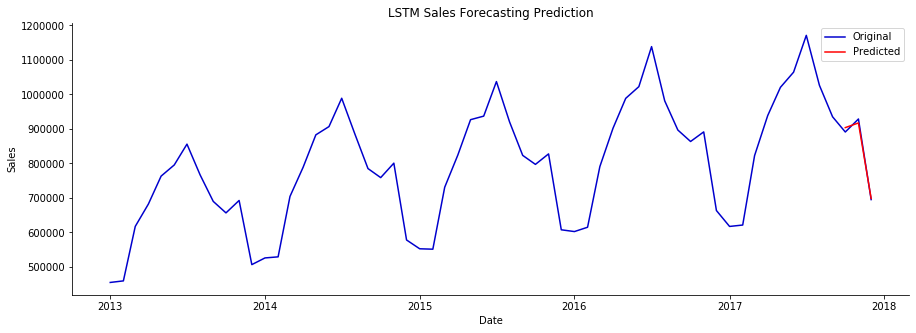

In [40]:
lstm_model(train, test)

In [41]:
pickle.dump(model_scores, open( "model_scores.p", "wb" ) )

### 5.3.2 ARIMA Model  (SARIMAX)
We are going to apply one of the most commonly used method for time-series forecasting, known as ARIMA, which stands for Autoregressive Integrated Moving Average.

ARIMA models are denoted with the notation ARIMA(p, d, q). These three parameters account for seasonality, trend, and noise in data.

* AR: Auto-Regressive (p): AR terms are just lags of dependent variable. For example lets say p is 3, we will use x(t-1), x(t-2) and x(t-3) to predict x(t)
* I: Integrated (d): These are the number of nonseasonal differences. 
* MA: Moving Averages (q): MA terms are lagged forecast errors in prediction equation.

In [42]:
ts_data = arima_df.copy()
ts_data.index = pd.to_datetime(ts_data.index)

In [43]:
def get_scores(data):
    
    model_scores = {}
    
    rmse = np.sqrt(mean_squared_error(data.sales_diff[-3:], data.forecast[-3:]))
    mae = mean_absolute_error(data.sales_diff[-3:], data.forecast[-3:])
    r2 = r2_score(data.sales_diff[-3:], data.forecast[-3:])
    model_scores['ARIMA'] = [rmse, mae, r2]
    
    print(f"RMSE: {rmse}")
    print(f"MAE: {mae}")
    print(f"R2 Score: {r2}")
    
    pickle.dump(model_scores, open( "arima_model_scores.p", "wb" ))

/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


RMSE: 6497.006328877199
MAE: 6108.717734702834
R2 Score: 0.9967320458096489


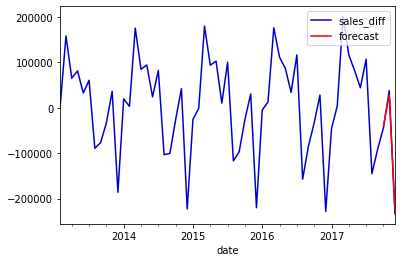

In [44]:
# predict sales_diff and plot
def sarimax_model(data):
    
    # Model
    sar = sm.tsa.statespace.SARIMAX(ts_data.sales_diff, order=(12,0,0), seasonal_order=(0,1,0,12), trend='c').fit()

    # Predictions
    start, end, dynamic = pd.to_datetime('2017-10-01'),pd.to_datetime('2017-12-01'), False
    data['forecast'] = sar.predict(start=start, end=end, dynamic=dynamic) 
    pred_df = data.forecast[start:end]
    
    data[['sales_diff', 'forecast']].plot(color=['mediumblue', 'Red'])
    
    get_scores(data)

    return sar, data, pred_df

sar, ts_data, predictions = sarimax_model(ts_data)

In [45]:
def predict_df(prediction_df):
    
    #load in original dataframe without scaling applied
    original_df = data.copy()
    original_df.date = original_df.date.apply(lambda x: str(x)[:-3])
    original_df = original_df.groupby('date')['sales'].sum().reset_index()
    original_df.date = pd.to_datetime(original_df.date)
    
    #create dataframe that shows the predicted sales
    result_list = []
    sales_dates = list(original_df[-4:].date)
    act_sales = list(original_df[-4:].sales)
    
    for index in range(0,len(prediction_df)):
        result_dict = {}
        result_dict['pred_value'] = int(prediction_df[index] + act_sales[index])
        result_dict['date'] = sales_dates[index+1]
        result_list.append(result_dict)
        
    df_result = pd.DataFrame(result_list)
    
    return df_result, original_df

In [46]:
def plot_results(results, original_df, model_name):

    fig, ax = plt.subplots(figsize=(15,5))
    sns.lineplot(original_df.date, original_df.sales, data=original_df, ax=ax, 
                label='Original', color='mediumblue')
    sns.lineplot(results.date, results.pred_value, data=results, ax=ax, 
                 label='Predicted', color='Red')
    
    ax.set(xlabel = "Date",
           ylabel = "Sales",
           title = f"{model_name} Sales Forecasting Prediction")
    
    ax.legend()
    
    sns.despine()

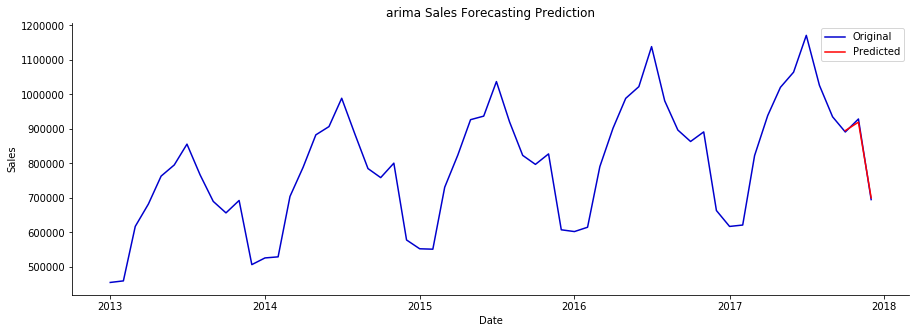

In [47]:
prediction_df, original_df = predict_df(predictions)
plot_results(prediction_df, original_df, 'arima')

We can also get dynamic predictions. One-step-ahead prediction uses the true values of the endogenous values at each step to predict the next in-sample value. Dynamic predictions use one-step-ahead prediction up to some point in the dataset (specified by the dynamic argument); after that, the previous predicted endogenous values are used in place of the true endogenous values for each new predicted element.

## 5.4 Model Selection

In [48]:
def create_results_df():
    results_dict = pickle.load(open("model_scores.p", "rb"))
    
    results_dict.update(pickle.load(open("arima_model_scores.p", "rb")))
    
    restults_df = pd.DataFrame.from_dict(results_dict, orient='index', 
                                        columns=['RMSE', 'MAE','R2'])
    
    restults_df = restults_df.sort_values(by='RMSE', ascending=False).reset_index()
    
    return restults_df

In [49]:
results = create_results_df()
results

,index,RMSE,MAE,R2
0,LinearRegression,13034.263027,10832.000000,0.983808
1,LSTM,10036.732320,9115.000000,0.990399
2,ARIMA,6497.006329,6108.717735,0.996732


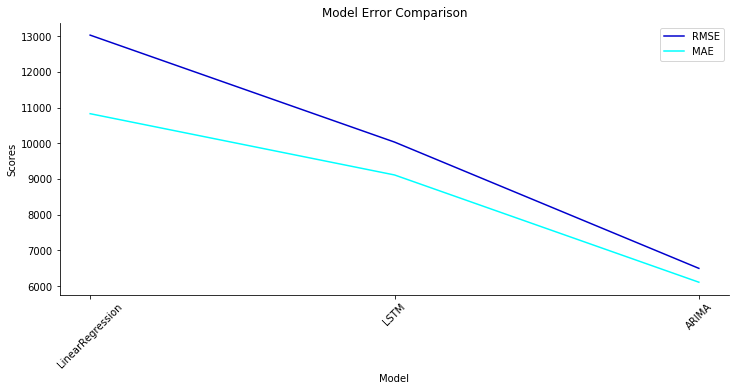

In [50]:
def plot_results(results_df):
    fig, ax = plt.subplots(figsize=(12, 5))
    sns.lineplot(np.arange(len(results_df)), 'RMSE', data=results_df, ax=ax, 
                 label='RMSE', color='mediumblue')
    sns.lineplot(np.arange(len(results_df)), 'MAE', data=results_df, ax=ax, 
                 label='MAE', color='Cyan')
    
    plt.xticks(np.arange(len(results_df)),rotation=45)
    ax.set_xticklabels(results_df['index'])
    ax.set(xlabel = "Model",
           ylabel = "Scores",
           title = "Model Error Comparison")
    sns.despine()
    

plot_results(results)